In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.DataFrame(yf.download('^GSPC'))
df = df['2005':'2020']

[*********************100%***********************]  1 of 1 completed


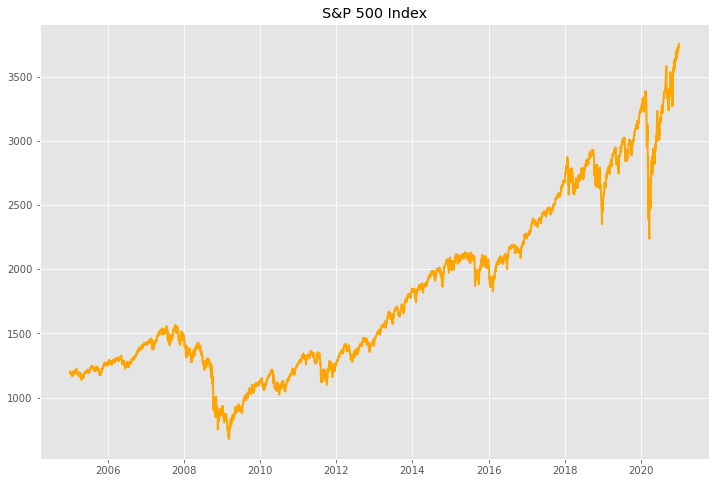

In [5]:
# Visualize FTSE 100 Index Price
plt.plot(df['Adj Close'], color='orange')
plt.title('S&P 500 Index')
plt.grid(True)

In [6]:
# Calculate daily returns
returns = np.log(df['Adj Close']).diff().fillna(0)

In [7]:
np.var(returns)

0.00015600867905055465

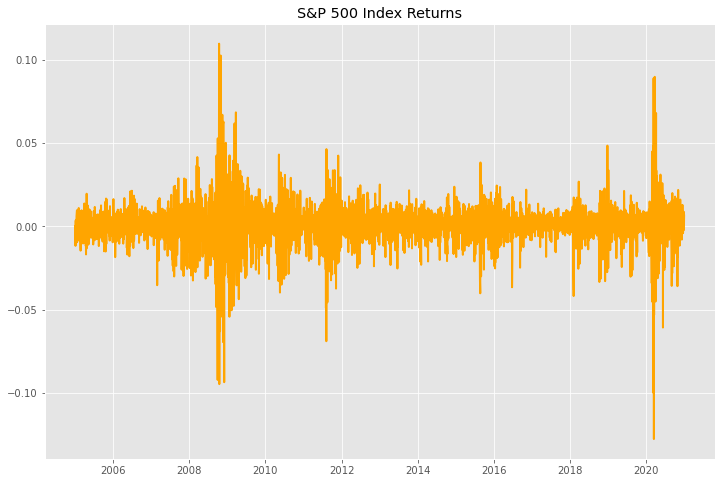

In [8]:
# Visualize FTSE 100 Index daily returns
plt.plot(returns, color='orange')
plt.title('S&P 500 Index Returns')
plt.grid(True)

In [9]:
# GARCH(1,1) function
def garch(omega, alpha, beta, ret):
    
    length = len(ret)
    
    var = []
    for i in range(length):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [10]:
garch(np.var(returns),0.1,0.8,returns)[:3]

array([0.00156009, 0.00140408, 0.00129305])

In [11]:
# Log likelihood function
def likelihood(params, ret):
    
    length = len(ret)
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    
    variance = garch(omega, alpha, beta, ret)
    
    llh = []
    for i in range(length):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [12]:
likelihood((np.var(returns), 0.1, 0.8),returns)

-10252.889301845556

In [13]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = ((np.var(returns), 0.1, 0.8))

In [14]:
res = minimize(likelihood, initial_values, args = returns, 
                   method='Nelder-Mead', options={'disp':False})

In [15]:
res['x']

array([2.64648957e-06, 1.31570491e-01, 8.45116052e-01])

In [16]:
# GARCH parameters
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0003, 'alpha': 13.157, 'beta': 84.5116}

In [17]:
# Parameters
omega = res['x'][0] 
alpha = res['x'][1]
beta = res['x'][2]

# Variance
var = garch(res['x'][0],res['x'][1],res['x'][2],returns)

# Annualised conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol

array([16.91344308, 15.76156409, 16.19618919, ..., 10.54227314,
       10.11155535,  9.67846792])

In [18]:
vix = pd.DataFrame(yf.download('^VIX'))

[*********************100%***********************]  1 of 1 completed


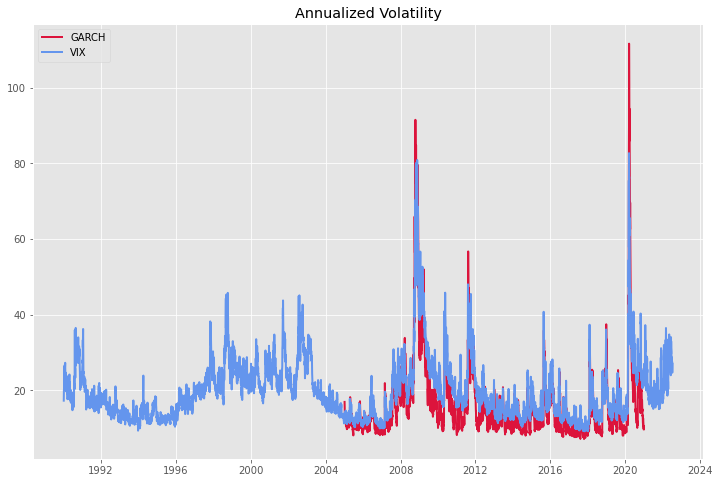

In [19]:
# Visualise GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='crimson', label='GARCH')
plt.plot(vix.index, vix['Adj Close'], color='cornflowerblue', label = 'VIX')
plt.legend(loc=2)
plt.grid(True)

In [20]:
# Calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)
 
fvar = []
for i in range(1,732):    
    fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))

var = np.array(fvar)

In [21]:
# Verify first 10 values
var[:10]

array([3.89516109e-05, 4.06900038e-05, 4.23878687e-05, 4.40461505e-05,
       4.56657721e-05, 4.72476346e-05, 4.87926185e-05, 5.03015835e-05,
       5.17753692e-05, 5.32147960e-05])

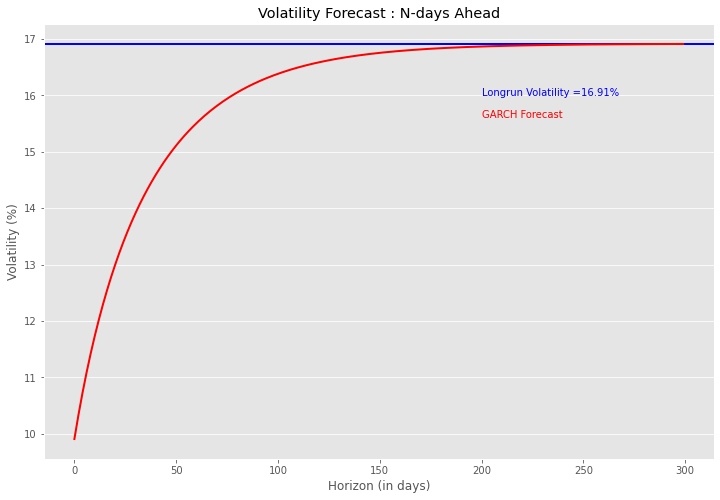

In [22]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='blue')
plt.plot(np.sqrt(var[:300]*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(200,15.60), color='red')
plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
             xy=(200,16), color='blue')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(axis='x')

In [23]:
# Import arch library
from arch import arch_model

In [24]:
# Mean zero
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')

In [25]:
model = g1.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -13200.468236187386
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13200.468222727926
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [26]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13200.5
Distribution:                  Normal   AIC:                          -26394.9
Method:            Maximum Likelihood   BIC:                          -26376.0
                                        No. Observations:                 4028
Date:                Tue, Jul 12 2022   Df Residuals:                     4028
Time:                        07:53:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.1218e-06  8.435e-10   3700.901      0.000 [3.

In [27]:
# Model params
model.params

omega       0.000003
alpha[1]    0.200000
beta[1]     0.780000
Name: params, dtype: float64

In [28]:
# Model Confidence Interval
model.conf_int(alpha=.05)

,lower,upper
omega,0.000003,0.000003
alpha[1],0.180384,0.219616
beta[1],0.764148,0.795852


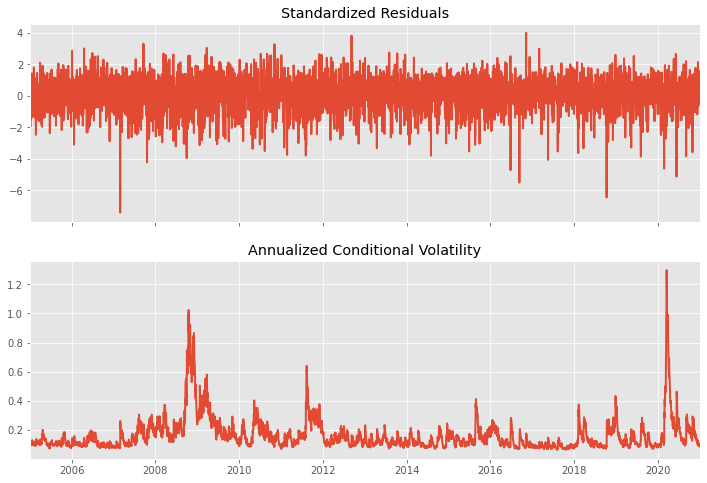

In [29]:
# Plot annualised vol
fig = model.plot(annualize='D')

In [30]:
model.conditional_volatility*np.sqrt(252)

Date
2005-01-03    0.101752
2005-01-04    0.094140
2005-01-05    0.121020
2005-01-06    0.113473
2005-01-07    0.106993
                ...   
2020-12-24    0.089681
2020-12-28    0.087682
2020-12-29    0.102882
2020-12-30    0.096402
2020-12-31    0.090145
Name: cond_vol, Length: 4028, dtype: float64

In [31]:
# Forecast for next 5 days
model_forecast = model.forecast(horizon=60)

In [32]:
# Subsume forecast values into a dataframe
forecast_df = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T *252)*100)
forecast_df.columns = ['Cond_Vol']
forecast_df.head()

,Cond_Vol
h.01,9.592299
h.02,9.901456
h.03,10.195338
h.04,10.475347
h.05,10.742677


In [33]:
# long run variance from model forecast
lrv = model.params[0]/(1-model.params[1]-model.params[2])

# long run variance
np.sqrt(lrv*252)*100

19.832888887361918

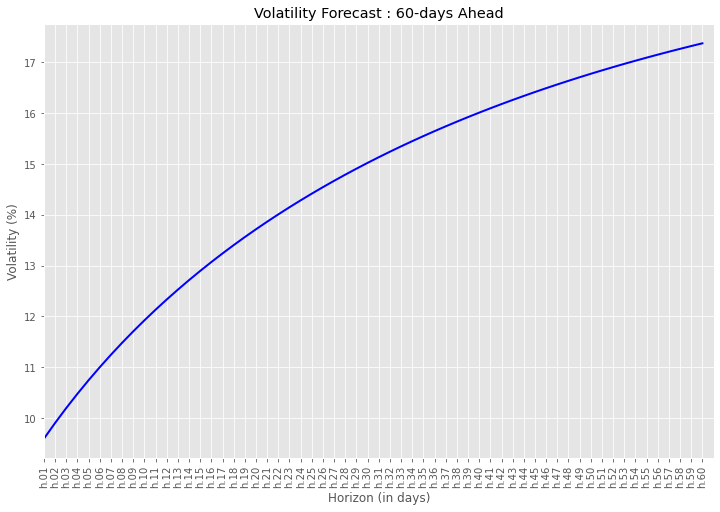

In [34]:
# Plot volatility forecast over a 60-day horizon
plt.plot(forecast_df, color='blue')
plt.xlim(0,60)
plt.xticks(rotation=90)
plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')
plt.title('Volatility Forecast : 60-days Ahead');
plt.grid(True)